<a href="https://colab.research.google.com/github/EliseuODaniel/analise_de_sentimentos_eleicao/blob/main/Copy_of_analise_sentimento_com_bert_Tweets_bolsonaroipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de sentimento com Bert

## Projeto integrador

## Classificação de Texto

utilização da arquitetura BERTimbau, versão em Português do BERT

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 15.5 MB/s 
     |████████████████████████████████| 163 kB 71.1 MB/s 
     |████████████████████████████████| 7.6 MB 59.6 MB/s 


In [4]:
import os
import torch
import torch.nn as nn
from torch import optim
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [5]:

import pandas as pd
import csv
from random import shuffle
import nltk
nltk.download('punkt')

# Lê o csv e transforma num dataframe

full_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tweets-bolsonaro_categorizado4.csv', sep=';')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28029 entries, 0 to 28028
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     28029 non-null  object 
 1   content  28029 non-null  object 
 2   label    225 non-null    float64
dtypes: float64(1), object(2)
memory usage: 657.1+ KB


In [7]:
# Drop rows with any empty cells in collumn 'label'
df = full_df.dropna(subset=['label'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 0 to 27977
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     225 non-null    object 
 1   content  225 non-null    object 
 2   label    225 non-null    float64
dtypes: float64(1), object(2)
memory usage: 7.0+ KB


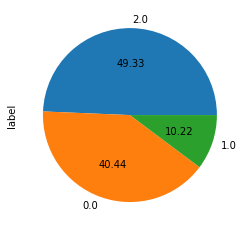

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

#  mostra a proporção de cada label, se não está balanceado, acurácia não é uma boa métrica
df['label'].value_counts().plot.pie(autopct='%.2f')

In [10]:
# converte dataframe em lista de listas
tweets_list = df.values.tolist()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


presidente    1858
brasil        1550
agora         1073
votar          943
governo        901
voto           893
cara           855
anos           853
janones        844
tudo           830
turno          805
contra         804
gente          792
povo           789
censurou       734
ainda          713
pode           696
todos          696
nada           693
jair           672
dtype: int64


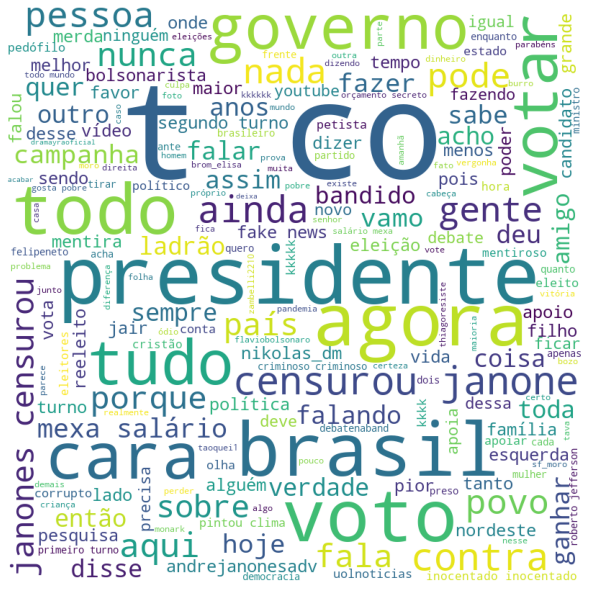

In [11]:
# cria uma nuvem de palavras


import nltk
nltk.download('punkt')
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
stop_words = stop_words + list(['jairbolsonaro','lula','lulaoficial','Lula','inocente','bolsonaro',',','.','https', ':','!', '#', '@', '?', '/', 'O', 'vai', '|', '–','pra', 'a', 'e', '-'])

def remove_stopwords(x):
  word_tokens = nltk.word_tokenize(x)
  # print(word_tokens)
  filtered_sentence = ' '.join([w for w in word_tokens if not (w in stop_words or len(w)<4)]) 
  return filtered_sentence

tweets_bolsonaro = full_df

#convert to string and lowercase sentences 
tweets_bolsonaro['content'] = tweets_bolsonaro['content'].astype(str).str.lower()


tweets_bolsonaro['filtered_text'] = tweets_bolsonaro['content'].apply(lambda x: remove_stopwords(x))

# filter tweets_bolsonaro by day - para caso queira mostrar quais palavras foram mais citadas a cada dia
# for day in tweets_bolsonaro['date'].unique():
#     print("\nday: ", day)
#     tweets_bolsonaro = tweets_bolsonaro[tweets_bolsonaro['date'] == day]
#     word_count = pd.Series(' '.join(tweets_bolsonaro_day['filtered_text'].str.lower()).split()).value_counts()[:20]
#     print(word_count)

word_count = pd.Series(' '.join(tweets_bolsonaro['filtered_text'].str.lower()).split()).value_counts()[:20]
print(word_count)

# create a word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(' '.join(tweets_bolsonaro['filtered_text']))

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

cria uma lista com dicionarios de reviews e rating

In [12]:
#print(tweets_list)

In [13]:
#tweets_list 

In [14]:
tweets = [str(w[1]) for w in tweets_list]
ratings = [int(w[2]) for w in tweets_list]
data = [{ 'X': tweets, 'y': rating } for (tweets, rating) in zip(tweets, ratings)]

In [15]:
#print(data)

In [16]:
#print(type(data))
#print(data)

Separando os dados em conjunto de treino e teste

In [17]:
size = int(len(data) * 0.1)
treino = data[2*size:] #  0.2 - 1
validacao = data[size:2*size] # 0.1:0.2
teste = data[:size]  # 0:0.1

len(treino), len(validacao), len(teste)

(181, 22, 22)

BERTimbau - documentação [este link](https://github.com/neuralmind-ai/portuguese-bert).

Configurando hiper parâmetros

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # define qual será o acelerador gráfico onde o modelo será processado
nclasses = 3  # número de classes/labels que classificam  os tweets (0 = negativo, 1 = indefinido, 2 = positivo)
nepochs = 10  # número de épocas (valor inicial: 5)
batch_size = 8 # número mínimo de frases que são previstas por vez - recomendação autores bert: Batch size: 16, 32 (maior batch usa menos memória)
batch_status = 32  # a cada quantas batches avalia o status - numero menor pra dataset menor
learning_rate = 2e-5  # taxa de aprendizado - recomendação autores bert Learning rate (Adam): 5e-5, 3e-5, 2e-5 (1e-5 usa menos memória)
early_stop = 2  # critério de parada, quantas epocas sem melhora do f1 para parar o aprendizado

max_length = 200 # tamanho maximo de cada frase
write_path = 'model'

Separando os dados em batches de treino e teste



In [19]:
from torch.utils.data import DataLoader

traindata = DataLoader(treino, batch_size=batch_size, shuffle=True)
validationdata = DataLoader(validacao, batch_size=batch_size, shuffle=True)
testdata = DataLoader(teste, batch_size=batch_size, shuffle=True)

In [20]:
# conteúdo do dataloader
for batch_idx, inp in enumerate(traindata):
    print(batch_idx) #o índice do batch
    print(inp) # os batches, dicionário de X com os textos e Y transformado em tensor com os labels
    break

0
{'X': ['🇧🇷🇧🇷 BOLSONARO 22 BOLSONARO 22. Você percebe a atitude do Capitão ??  Chamou todos presentes pra dentro da van que é blindada. Capitão pensam no bem de TODOS.    Olha isso São Paulo. 👀#somostodosbolsonaro https://t.co/le9lzXvLRS', 'Será que nossas Forças Armadas aceitariam José Dirceu como Ministro da Defesa caso Lula seja eleito? Existe esse boato na rede. Gedel o homem da mala também contato p Ministro.  #bolsonaro #GloboLixo', '@Helena1Patr BOLSONARO PEDÓFILO 🤮🤮🤮', 'Nordestinos do Brasil inteiro não pode votar no Bozo e seus bozominions. Não nos respeitam e não deverão ter nossos votos. #HaddadGovernadorSP1️⃣3️⃣ #LulaPresidente1⃣3⃣ Em novo ato de xenofobia, Bolsonaro diz que PT usou nordestinos "para roubar a nação" https://t.co/Pk8DX3MEDC', '@LulaOficial 13 mentiras.....13 o número da desgraça..... melhor mesmo é 22  na sua cara...aliás nove dedos, recomendo a vc votar 22...seu país agradece', '@YpeOficial Empresa suja, fora bolsonaro, fora fascistas', 'Olha que nojo.    

instanciando tokenizador, modelo, função de erro e otimizador:

In [21]:
# instancia o tokenizador
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-large-portuguese-cased', do_lower_case=False)  # para utilizar o BERTinbal large: 'neuralmind/bert-large-portuguese-cased'
#bertinbal menor: 'neuralmind/bert-base-portuguese-cased'
#  instancia o modelo
model = AutoModelForSequenceClassification.from_pretrained('neuralmind/bert-large-portuguese-cased', num_labels=nclasses).to(device)

# seleciona o otimizador 
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# congela os pesos do BERT pré-treinado
for param in model.base_model.parameters():
    param.requires_grad = False

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at neuralmind/bert-large-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from th

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


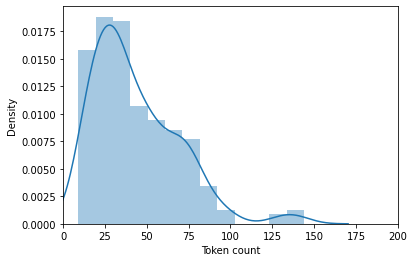

In [22]:
import seaborn as sns
# verificando a distribuição e o tamanho máximo dos tokens
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 200]);
plt.xlabel('Token count');

Funcionamento do tokenizador

In [23]:
tokens = tokenizer.encode("bonito carro", return_tensors="pt")
print("frase tokenizada no formato de tensor pytorch:")
tokens[0]
# codifiga cada palavra com um token e adiciona o token de CLS (classificação) e de final de frase (SEP)

frase tokenizada no formato de tensor pytorch:


tensor([  101, 22003,  3883,   102])

In [24]:
tokens = tokenizer.encode("carro bonito", return_tensors="pt").to(device)
print("frase tokenizada no formato de tensor pytorch:")
tokens[0]

frase tokenizada no formato de tensor pytorch:


tensor([  101,  3883, 22003,   102], device='cuda:0')

In [25]:
print("frase destokenizada:")
tokenizer.decode(tokens[0])

frase destokenizada:


'[CLS] carro bonito [SEP]'

funcionamento do modelo

In [26]:
result = model(tokens)
result
# a saída é uma lista de scores one-hot encoded
# como ao ser instanciado o modelo, foi escolhido o número de classes como 3, a saída será de 3 números diferentes
# cada posição com um significado diferente, conforme o que for utilizado nos dados de treino
# no exemplo a posição 1 (0.0417) é a maior (como o modelo ainda não foi treinado, o significado é aleatório)
# caso o modelo for treinado com a classificação 0=ruim, 1=neutro, 2=bom, a posição com número maior irá indicar o sentimento geral da frase


SequenceClassifierOutput(loss=None, logits=tensor([[-0.3483, -0.1720, -0.0204]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [27]:
#exemplo do tokenizer em funcionamento
# conteúdo do dataloader
for batch_idx, inp in enumerate(traindata):
    texts, labels = inp['X'], inp['y']

    print(texts[0],"\n")
    tokens = tokenizer.encode(texts[0], return_tensors="pt")
    print("frase tokenizada no formato de tensor pytorch:")
    print(tokens[0])
    print("label da frase tokenizada:")
    print(labels[0],"\n")

    # instancia o tokenizador enviando os textos dos comentarios
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)

    print(f"inputs[0]:\n {inputs[0]}\n")
    print(f"chaves do dicionário inputs:\n {inputs.keys()}\n")
    print(f'input_ids (frase tokenizada):\n {inputs["input_ids"][0]}\n')
    print(f'token_type_ids:\n {inputs["token_type_ids"][0]}\n')
    print(f'attention_mask:\n {inputs["attention_mask"][0]}')
    

    # saída é:
    # input_ids = transformações do texto em números, embeddings. onde 101 é token inicial
    # attention_mask = tensor que diz quais tokens devem receber atenção pelo modelo
    break


“Bolsonaro pela economia” -economistas apoiam lula  “Bolsonaro por Deus” -os padres apoiam lula   Na última eleição dava pra “entender” o voto nele, mas agora não. Quem votar é muito, mas muito mal caráter 

frase tokenizada no formato de tensor pytorch:
tensor([  101,  1112, 20354,   716,   157,   412,  3338, 22354,   118, 19232,
        22281,  6492, 22287,   599,   266,  1112, 20354,   716,   157,   240,
         2538, 22354,   118,   259, 13918,  6492, 22287,   599,   266,   503,
         2338,  4451, 10348,  1174,  1112,  9050, 22354,   146,  7509,  8807,
          117,   449,  2535,   346,   119, 15807, 15857,   253,   785,   117,
          449,   785,  3002,  5571,   102])
label da frase tokenizada:
tensor(0) 

inputs[0]:
 Encoding(num_tokens=87, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

chaves do dicionário inputs:
 dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids (frase tokenizada):
 tensor([  101,  1

In [28]:
# funcionamento do modelo
with torch.no_grad():
    model.eval()
    output = model(inputs['input_ids'], inputs['attention_mask'])

    #resultado (passa informações no modelo e ele gera uma lista contendo as saídas numa lista de tensores)
    #este modelo já tem camadas densas anexadas à saída do encoder que geram uma lista de probabilidades 
    #o resultado do modelo pre treinado

    #formato da saída:
    print(output[0][0])

    # como definiu-se 3 labels, a saída é um tensor de 3 números para cada label respectiva
    # onde o maior número significa a probabilidade de ser aquela label
    # 0 = positivo, 1 = indefinido, 2 = positivo
    print(output[0].shape) # o shape da saída mostra quantas frases tinha em cada batch (primeiro número) e quantas labels em cada frase(segundo número)


    

tensor([-0.2116,  0.0180, -0.1400], device='cuda:0')
torch.Size([8, 3])


In [29]:
# para extrair a informação do resultado:
torch.argmax(result.logits)

tensor(2, device='cuda:0')

Definindo a função de avaliação do modelo

In [30]:
def evaluate(model, validationdata):
  """
  avalia o desempenho do modelo que está sendo treinado baseado nos dados de validacao
  """
  # coloca o modelo no modo de avaliação
  model.eval()
  y_real, y_pred = [], []
  for batch_idx, inp in enumerate(validationdata): # passa por cada batch dos dados de teste, batch_idx é o número da batch, inp contem o texto e o label
    texts, labels = inp['X'], inp['y']
    
    # instancia o tokenizador enviando os textos dos comentarios
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    # instancia o modelo enviando os tokens e salvando as classificações preditas
    output = model(**inputs)
    
    # cria um tensor com os labels preditos no output
    pred_labels = torch.argmax(output.logits, 1)

    # print(f"texto: {texts}, rótulo correto: {labels}, predito pelo modelo: {pred_labels}") # imprime a frase, o resultado correto e o predito
    
    # adiciona cada novo label às listas y_real e y_pred(ito)
    y_real.extend(labels.tolist())
    y_pred.extend(pred_labels.tolist())
    
    # a cada certa quantidade de itens preditos, printa a % de progresso e o número de itens preditos
    if (batch_idx+1) % batch_status == 0:
      print('Progress:', round(batch_idx / len(testdata), 2), batch_idx)
  
  # chama o classification_report do scikitlearn para calcular o resultado após predizer todas as linhas de teste
  print(classification_report(y_real, y_pred, labels=[0, 1, 2], target_names=['Negative', 'Neural', 'Positive'])) # identifica os labels 0, 1 e 2 como negativo, neutro e positivo
  # retorna f1 e acurácia
  f1 = f1_score(y_real, y_pred, average='weighted')
  acc = accuracy_score(y_real, y_pred)
  return f1, acc

Treinamento

In [31]:
max_f1, repeat = 0, 0

#  passa por todas as épocas de treino
for epoch in range(nepochs):
  #seleciona o modo de treino do modelo
  model.train()
  losses = []

  for batch_idx, inp in enumerate(traindata): # passa por cada batch dos dados de teste, batch_idx é o número da batch, inp contem o texto e o label
    texts, labels = inp['X'], inp['y']

    # instancia o tokenizador enviando os textos dos comentarios
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    # zera os gradientes acumulados em buffer 
    optimizer.zero_grad()
    # instancia o modelo enviando os tokens e salvando as classificações preditas
    output = model(**inputs, labels=labels.to(device))

    # calcula a perda
    loss = output.loss
    losses.append(float(loss))

    # faz o Backpropagation no modelo- com o otimizador definido anteriormente (AdamW)
    loss.backward()
    optimizer.step()

    # mostra o andamento do treinamento
    if (batch_idx+1) % batch_status == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTotal Loss: {:.6f}'.format(\
        epoch, # número da época
        batch_idx+1, # número do batch
        len(traindata), # número total de dados de treino
        100. * batch_idx / len(traindata), # % de dados treinados
        float(loss), # perda atual
        round(sum(losses) / len(losses), 5) # perda acumulada
        ))

  # se passou a 1a época, descongela os pesos do Bert pretreinado
  if epoch == 0: 
    for param in model.base_model.parameters():
        param.requires_grad = True

  # ao terminar cada época, avalia o modelo
  f1, acc = evaluate(model, validationdata)
  print('F1: ', f1, 'Accuracy: ', acc)

  # salva o modelo somente se f1 melhorou em relação à epoch anterior
  if f1 > max_f1:
    model.save_pretrained(os.path.join(write_path, 'model'))
    max_f1 = f1
    repeat = 0
    print('Saving best model...')
  else:
    repeat += 1
  
  # se por duas épocas o f1 não melhorou, para de treinar o modelo
  if repeat == early_stop:
    break

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        14
      Neural       0.00      0.00      0.00         3
    Positive       0.21      0.60      0.32         5

    accuracy                           0.14        22
   macro avg       0.07      0.20      0.11        22
weighted avg       0.05      0.14      0.07        22

F1:  0.07177033492822966 Accuracy:  0.13636363636363635
Saving best model...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        14
      Neural       0.00      0.00      0.00         3
    Positive       0.23      1.00      0.37         5

    accuracy                           0.23        22
   macro avg       0.08      0.33      0.12        22
weighted avg       0.05      0.23      0.08        22

F1:  0.08417508417508417 Accuracy:  0.22727272727272727
Saving best model...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Negative       0.71      0.36      0.48        14
      Neural       0.00      0.00      0.00         3
    Positive       0.20      0.60      0.30         5

    accuracy                           0.36        22
   macro avg       0.30      0.32      0.26        22
weighted avg       0.50      0.36      0.37        22

F1:  0.37121212121212127 Accuracy:  0.36363636363636365
Saving best model...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Negative       0.80      0.57      0.67        14
      Neural       0.00      0.00      0.00         3
    Positive       0.25      0.60      0.35         5

    accuracy                           0.50        22
   macro avg       0.35      0.39      0.34        22
weighted avg       0.57      0.50      0.50        22

F1:  0.5044563279857397 Accuracy:  0.5
Saving best model...
              precision    recall  f1-score   support

    Negative       0.92      0.86      0.89        14
      Neural       1.00      0.33      0.50         3
    Positive       0.50      0.80      0.62         5

    accuracy                           0.77        22
   macro avg       0.81      0.66      0.67        22
weighted avg       0.84      0.77      0.77        22

F1:  0.7736985236985238 Accuracy:  0.7727272727272727
Saving best model...
              precision    recall  f1-score   support

    Negative       0.83      0.36      0.50     

In [32]:
  # avaliação final do modelo nos dados de teste
  f1, acc = evaluate(model, testdata)
  print('F1: ', f1, 'Accuracy: ', acc)

              precision    recall  f1-score   support

    Negative       0.38      0.60      0.46         5
      Neural       0.50      0.20      0.29         5
    Positive       0.75      0.75      0.75        12

    accuracy                           0.59        22
   macro avg       0.54      0.52      0.50        22
weighted avg       0.61      0.59      0.58        22

F1:  0.5789210789210789 Accuracy:  0.5909090909090909


In [46]:
texts = "bolsonaro é horrível"

# instancia o tokenizador enviando os textos dos comentarios
inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
# instancia o modelo enviando os tokens e salvando as classificações preditas
output = model(**inputs)

# cria um tensor com os labels preditos no output
pred_labels = torch.argmax(output.logits, 1).item()

print(f"texto: {texts}, rótulo predito pelo modelo: {pred_labels}") # imprime a frase, o resultado correto e o predito

texto: bolsonaro é horrível, rótulo predito pelo modelo: 0


In [47]:
texts = "bolsonaro é ótimo, votem 22"

# instancia o tokenizador enviando os textos dos comentarios
inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
# instancia o modelo enviando os tokens e salvando as classificações preditas
output = model(**inputs)

# cria um tensor com os labels preditos no output
pred_labels = torch.argmax(output.logits, 1).item()

print(f"texto: {texts}, rótulo predito pelo modelo: {pred_labels}") # imprime a frase, o resultado correto e o predito

texto: bolsonaro é ótimo, votem 22, rótulo predito pelo modelo: 2


In [35]:
texts = "tweet aleatório sem sentido"

# instancia o tokenizador enviando os textos dos comentarios
inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
# instancia o modelo enviando os tokens e salvando as classificações preditas
output = model(**inputs)

# cria um tensor com os labels preditos no output
pred_labels = torch.argmax(output.logits, 1).item()

print(f"texto: {texts}, rótulo predito pelo modelo: {pred_labels}") # imprime a frase, o resultado correto e o predito

texto: tweet aleatório sem sentido, rótulo predito pelo modelo: 0


In [36]:
#reduced_df = full_df.head(10000) # seleciona apenas 5000 linhas para teste
reduced_df = full_df

In [37]:

# iterates through the dataframe tweets_lula and prints the text of the 'content' column at each iteration
for index, row in reduced_df.iterrows():
    # instancia o tokenizador enviando os textos dos comentarios
    inputs = tokenizer(str(row['content']), return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(device)
    # instancia o modelo enviando os tokens e salvando as classificações preditas
    output = model(**inputs)
    # cria um tensor com os labels preditos no output e extrai a predição do tensor
    reduced_df['label'][index] = torch.argmax(output.logits).item()

    if index % 2000 == 0:
      print(f"{index}/{len(reduced_df)}")
    #print(reduced_df['label'])
    


0/28029


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2000/28029
4000/28029
6000/28029
8000/28029
10000/28029
12000/28029
14000/28029
16000/28029
18000/28029
20000/28029
22000/28029
24000/28029
26000/28029
28000/28029


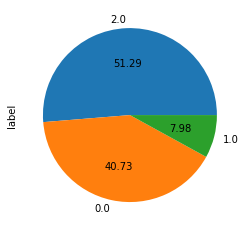

In [38]:
# nmostra a proporção de labels no resultado final total
reduced_df['label'].value_counts().plot.pie(autopct='%.2f')

In [39]:
# transforma a data em time series
reduced_df['date'] = pd.to_datetime(full_df['date'])


In [40]:
# agrupa o total de labels por dia
reduced_df_grouped = reduced_df.groupby(['label', pd.Grouper(key='date', freq='D')]).count()

In [41]:
reduced_df_grouped.head(10)

content  filtered_text
label date                              
0.0   2022-02-10      418            418
      2022-03-10      377            377
      2022-04-10      373            373
      2022-05-10      493            493
      2022-06-10      428            428
      2022-07-10      385            385
      2022-08-10      357            357
      2022-09-10      361            361
      2022-10-10      410            410
      2022-10-13      411            411

In [42]:
# faz o pivot transformando as linhas de diferente labels em colunas
reduced_df_grouped = reduced_df_grouped.pivot_table(index='date', columns='label', values='content')

In [43]:
#remove coluna com label 1 (indefinidos)
reduced_df_grouped = reduced_df_grouped.drop(columns=[1])

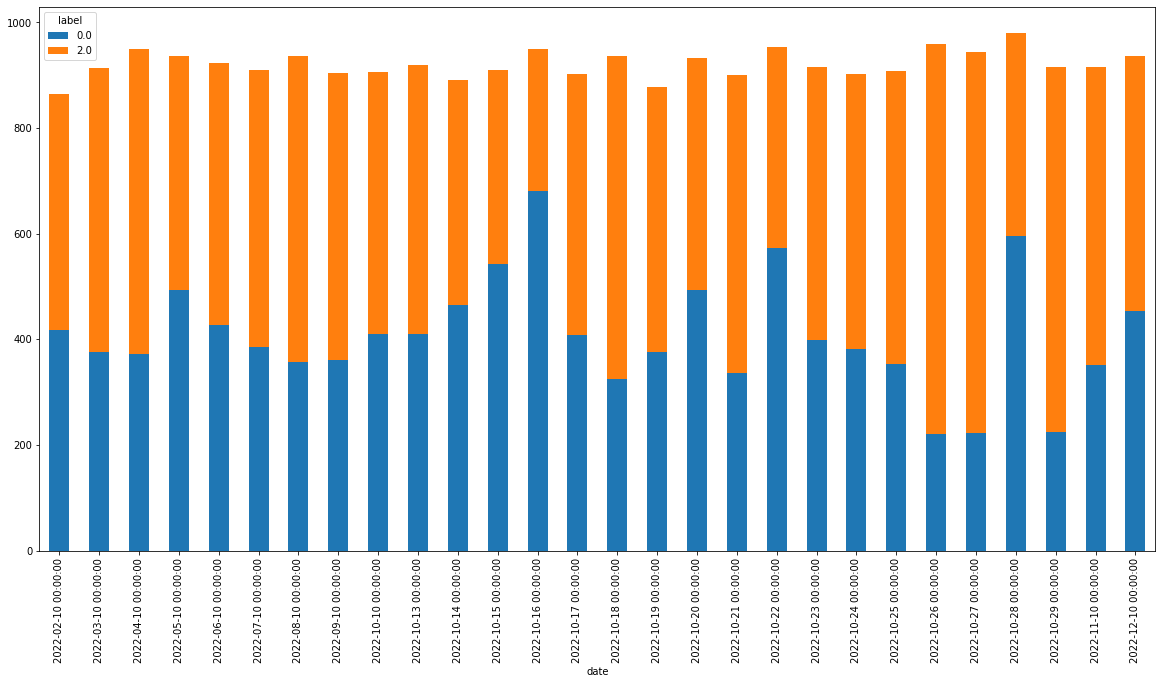

In [44]:
#plota o gráfico
reduced_df_grouped.plot(kind='bar', stacked=True, figsize=(20,10))

Text(0, 0.5, 'Porcentagem de cada Sentimento')

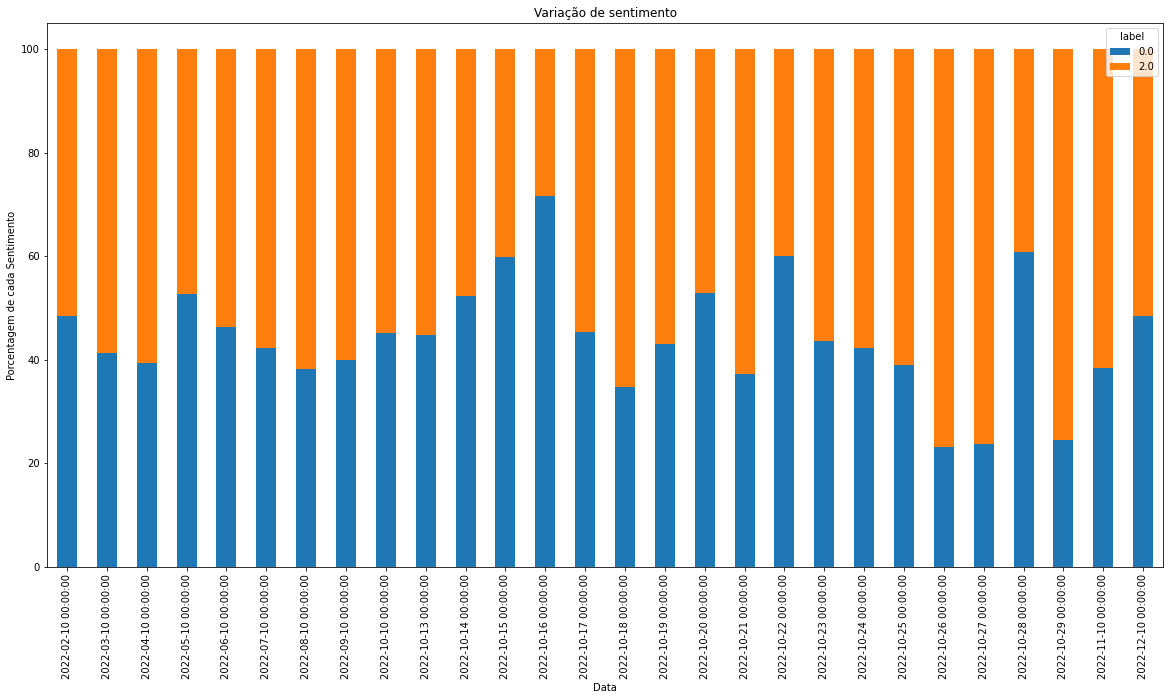

In [45]:
stacked_data = reduced_df_grouped.apply(lambda x: x*100/sum(x), axis=1)
stacked_data.plot(kind="bar", stacked=True,  figsize=(20,10))
plt.title("Variação de sentimento")
plt.xlabel("Data")
plt.ylabel("Porcentagem de cada Sentimento")